In [ ]:
#!pip install packaging
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from packaging import version
import time

assert(version.parse(tf.__version__) >= version.parse("2.0.0-aplha"))

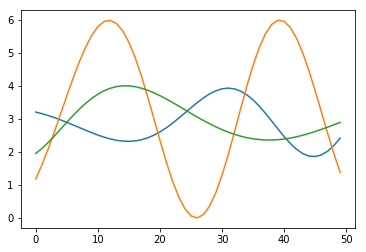

In [248]:
def generate_serie(size, step) :
    maxT = size*step
    t = np.arange(0, maxT, step)
#    return (np.sin(t+np.cos(t*0.31))).astype(np.float32)
    return ((np.sin(t+np.sin(t*.31)) * np.sin(t /10 / 3.3485)).astype(np.float32)+1)*3
#    return (np.sin(t+np.cos(t)) + .34158*np.sin(t * 3.3485)).astype(np.float32)
#return (t * np.sin(t)/maxT + .3*np.sin(t * 3.3)).astype(np.float32)

def split(arr, *count) :
    total = sum(count)
    p0 = 0
    for i in count :
        p1 = p0 + i
        yield arr[int(len(arr)*p0/total):int(len(arr)*p1/total)]
        p0 = p1
    
    
np.random.seed(42)

N_STEPS = n_steps = 50
data = generate_serie(14001, .18)
data = [(data[i:i+n_steps], data[i+1:i+n_steps+1]) for i in range(len(data)-n_steps-1)] 
np.random.shuffle(data)

#plt.plot(data[1][0])
#plt.plot(data[2][0])
#plt.plot(data[3][0])
#plt.show()

spt_data = np.reshape([data[i][0] for i in range(len(data))], (-1, n_steps, 1))
spt_lbl = np.reshape([data[i][1] for i in range(len(data))], (-1, n_steps, 1))

train_size = 50
valid_size = 40
test_size = 10

[train, valid, test] = zip(split(spt_data, train_size, valid_size, test_size), 
                           split(spt_lbl, train_size, valid_size, test_size))

plt.plot(train[0][1])
plt.plot(train[0][2])
plt.plot(train[0][3])
plt.show()

train = tf.data.Dataset.from_tensor_slices((train[0], train[1]))
valid = tf.data.Dataset.from_tensor_slices((valid[0], valid[1]))
test = tf.data.Dataset.from_tensor_slices((test[0], test[1]))
#train = train.batch(64, True)
#valid = valid.batch(64, True)
#test = test.batch(64, True)


In [259]:
class Encoder(tf.keras.Model):
  def __init__(self, hidden1, enc_units, batch_sz) : #, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.hidden1 = hidden1
    self.enc_units = enc_units
    self.batch_sz = batch_sz

    self.lstm = tf.keras.layers.LSTM(self.hidden1,
                                    return_sequences=True,
                                    #return_state=True,
                                    stateful=not True,
                                    #activation="relu",
                                    #activation="selu",
                                    #activation="linear",
                                    #recurrent_activation="selu",  
                                    recurrent_initializer='glorot_uniform')
    self.dense = tf.keras.layers.Dense(self.enc_units,
                                    activation="linear")

    
#  def call(self, x, initial_state=None): #, hidden):
  def call(self, x) :
    mean = tf.keras.backend.mean(x, [1], True)
    var = tf.keras.backend.var(x, [1], True)
    x = (x - mean) / tf.keras.backend.sqrt(var)
    
    #return x
    x = self.lstm(x) #, initial_state = hidden)
    x = self.dense(x)
    x = x * tf.keras.backend.sqrt(var) + mean
    return x

#  def reset_states(self) :
#    self.lstm.reset_states()

#  def reset_states(self, initial_state=None) :
#    #print(self.lstm.input_spec)
#    self.lstm.reset_states(initial_state)

#  def initialize_hidden_state(self):
#    return tf.zeros((self.batch_sz, self.enc_units))
 

Model: "encoder_126"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unified_lstm_11 (UnifiedLSTM multiple                  3840      
_________________________________________________________________
dense_11 (Dense)             multiple                  31        
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________
stateful False []
encoder (None, 50, 1) (None, 50, 1)


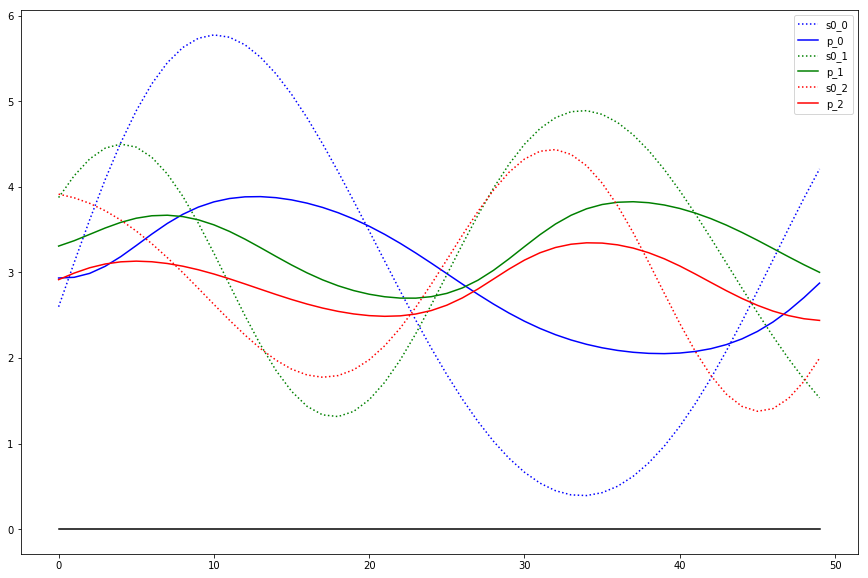

In [262]:
### Test

BATCH_SIZE = 8

encoder = Encoder(30, 1, BATCH_SIZE)
encoder.build(tf.TensorShape([BATCH_SIZE, None, 1]))
encoder.summary()
encoder.compile(optimizer="Adam", loss="MSE", metrics=['accuracy'])
encoder(tf.keras.Input(shape=(50, 1)))
print("stateful", encoder.stateful, encoder.state_updates)
print("encoder", encoder.input_shape, encoder.output_shape)
#print("lstm", encoder.lstm.input_shape, encoder.lstm.output_shape)
#print("dense", encoder.dense.input_shape, encoder.dense.output_shape)

val = encoder.predict(test.batch(BATCH_SIZE, True))

plt.figure(figsize=(15.0,10.0))
plt.plot(np.zeros(50), color='k')

colors = ['b','g','r']
for i in range(0,3) :
    plt.plot(list(test)[i][0], label="s0_" + str(i), linestyle=':', color=colors[i])
#    plt.plot(list(test)[i][1], label="s1_" + str(i))
    plt.plot(val[i], label="p_" + str(i), linestyle='-', color=colors[i])
#    plt.plot(val0[i], label="p_" + str(i), linestyle='-')
#    plt.plot(val1[i], label="p_" + str(i), linestyle='--')
plt.legend()
plt.show()


In [ ]:
BATCH_SIZE = 64 #*8

#encoder = Encoder(10, N_STEPS, BATCH_SIZE)
encoder = Encoder(10, 1, BATCH_SIZE)
encoder.build(tf.TensorShape([BATCH_SIZE, None, 1]))
encoder.summary()
encoder.compile(optimizer="Adam", loss="MSE", metrics=['accuracy'])
encoder(tf.keras.Input(shape=(50, 1)))
print("stateful", encoder.stateful, encoder.state_updates)
print("encoder", encoder.input_shape, encoder.output_shape)
#print("lstm", encoder.lstm.input_shape, encoder.lstm.output_shape)
#print("dense", encoder.dense.input_shape, encoder.dense.output_shape)

In [ ]:
EPOCHS = 12*5
EPOCHS = 8

#encoder.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError())
#print(len(train[0]))
#print(len(train[0])//BATCH_SIZE)
#print(len(train[0])//BATCH_SIZE*BATCH_SIZE)
#print(len(valid[0]))
#print(len(valid[0])//BATCH_SIZE)
#print(len(valid[0])//BATCH_SIZE*BATCH_SIZE)
#tbs = len(train[0])//BATCH_SIZE*BATCH_SIZE
#vbs = len(valid[0])//BATCH_SIZE*BATCH_SIZE

#a = encoder(train[0][:8])
#print(a)
#history = encoder.fit(train, epochs=EPOCHS) #, batch_size=BATCH_SIZE, shuffle=False)
#history = encoder.fit(train[0][:tbs], train[1][:tbs], epochs=EPOCHS, batch_size=BATCH_SIZE)
history = encoder.fit(train.batch(BATCH_SIZE, True), epochs=EPOCHS, validation_data=valid.batch(BATCH_SIZE, True), shuffle=False) # , batch_size=BATCH_SIZE
#history = encoder.fit(train.batch(BATCH_SIZE, True), epochs=EPOCHS, validation_data=valid.batch(BATCH_SIZE, True), callbacks=[ResetCallback()], shuffle=False) # , batch_size=BATCH_SIZE
#history = encoder.fit(train.batch(64, True), epochs=EPOCHS, validation_data=valid.batch(64, True), callbacks=[ResetCallback()], shuffle=False) # , batch_size=BATCH_SIZE
#history = encoder.fit(train[0][:tbs], train[1][:tbs], epochs=EPOCHS, validation_data=(valid[0][:vbs], valid[1][:vbs]), batch_size=BATCH_SIZE)
#a = encoder(train[0][:8])
#print(a)

In [ ]:
#print(history)
#print(history.history)
print(history.history.keys())

plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()
plt.plot(history.history['accuracy'], label="accuracy")
plt.plot(history.history['val_accuracy'], label="val_accuracy")
plt.legend()
plt.show()

In [ ]:
val = encoder.predict(test.batch(BATCH_SIZE, True))
val = encoder.predict(val)
val = encoder.predict(val)
#val = encoder.predict(val)
#val = encoder.predict(val)
#val = encoder.predict(val)

plt.figure(figsize=(15.0,10.0))
for i in range(0,3) :
    plt.plot(list(test)[i][0], label="s0_" + str(i), linestyle=':')
    plt.plot(list(test)[i
                       ][1], label="s1_" + str(i))
    plt.plot(val[i], label="p_" + str(i), linestyle='dashed')
plt.legend()
plt.show()
